In [18]:
!pip install pytorch-lightning

In [33]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pytorch_lightning import LightningModule, Trainer

In [20]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
             'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)

x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scalar = StandardScaler()
x = scalar.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
class DiabetesDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

train_data = DiabetesDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
test_data = DiabetesDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

In [22]:
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [23]:
class DiabetesPreidctionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(8, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [24]:
model = DiabetesPreidctionModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [25]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [26]:
model.train()
for e in range(1, 101):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = Variable(X_batch), Variable(y_batch)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    if e%10 == 0: print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.55291 | Acc: 69.250
Epoch 020: | Loss: 0.47934 | Acc: 76.500
Epoch 030: | Loss: 0.47325 | Acc: 77.250
Epoch 040: | Loss: 0.45717 | Acc: 79.400
Epoch 050: | Loss: 0.44545 | Acc: 79.600
Epoch 060: | Loss: 0.45265 | Acc: 80.000
Epoch 070: | Loss: 0.41877 | Acc: 80.550
Epoch 080: | Loss: 0.39844 | Acc: 81.500
Epoch 090: | Loss: 0.38298 | Acc: 83.000
Epoch 100: | Loss: 0.39793 | Acc: 81.650


In [27]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print(classification_report(y_test, y_pred_list, target_names=["Didn't Survive", "Survived"]))

                precision    recall  f1-score   support

Didn't Survive       0.81      0.79      0.80        99
      Survived       0.64      0.67      0.65        55

      accuracy                           0.75       154
     macro avg       0.73      0.73      0.73       154
  weighted avg       0.75      0.75      0.75       154



In [28]:
class DiabetesModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(8, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat, y.view(-1, 1))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat, y.view(-1, 1))
        y_hat = torch.sigmoid(y_hat)
        y_hat_tag = torch.round(y_hat)

        correct_sum = (y_hat_tag == y.view(-1, 1)).sum().float()
        acc = correct_sum / y.shape[0]
        acc = torch.round(acc * 100)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [29]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# ModelCheckpoint callback, would be a bonus point if students found this
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='output/checkpoint/',
    filename='diabetes-{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}',
    save_top_k=3,
    mode='max',
)

model = DiabetesModel()
trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/output/checkpoint exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | layer_1    | Linear      | 576    | train
1 | layer_2    | Linear      | 4.2 K  | train
2 | layer_out  | Linear      | 65     | train
3 | relu       | ReLU        | 0      | train
4 | dropout    | Dropout     | 0      | train
5 | batchnorm1 | BatchNorm1d | 128    | train
6 | batchnorm2 | BatchNorm1d | 128    | train
---------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


PYTORCH - LIGHTNING

In [30]:
class DiabetesModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(8, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat, y.view(-1, 1))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat, y.view(-1, 1))
        y_hat = torch.sigmoid(y_hat)
        y_hat_tag = torch.round(y_hat)

        correct_sum = (y_hat_tag == y.view(-1, 1)).sum().float()
        acc = correct_sum / y.shape[0]
        acc = torch.round(acc * 100)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [31]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# ModelCheckpoint callback, would be a bonus point if students found this
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='output/checkpoint/',
    filename='diabetes-{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}',
    save_top_k=3,
    mode='max',
)

model = DiabetesModel()
trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | layer_1    | Linear      | 576    | train
1 | layer_2    | Linear      | 4.2 K  | train
2 | layer_out  | Linear      | 65     | train
3 | relu       | ReLU        | 0      | train
4 | dropout    | Dropout     | 0      | train
5 | batchnorm1 | BatchNorm1d | 128    | train
6 | batchnorm2 | BatchNorm1d | 128    | train
---------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CONVOLUTION OPERATION

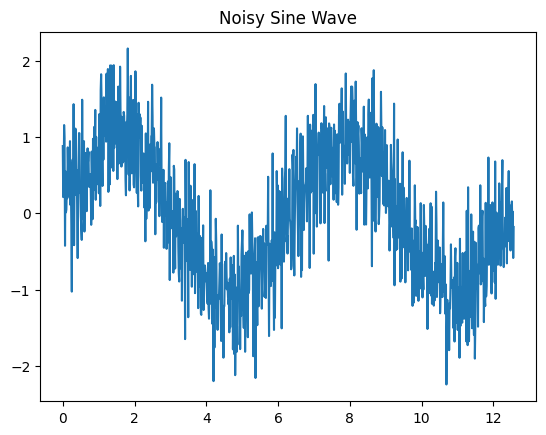

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# set random seed for reproducibility
np.random.seed(0)

# Define a 1000 point long sine wave and add some noise
n = 1000
mean = 0
std = 0.5

x = np.linspace(0, 4*np.pi, n)
# Adding noise
y = np.sin(x) + np.random.normal(mean, std, n)
y_sin = np.sin(x)

# Lets plot the noisy sine wave
plt.plot(x, y)
plt.title('Noisy Sine Wave')
plt.show()

In [36]:
def conv1d(data, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    pad = len(kernel) // 2
    data_padded = np.pad(data, pad, mode='edge')
    smooth_data = np.zeros_like(data)

    for i in range(pad, len(data_padded) - pad):
        smooth_data[i - pad] = np.sum(data_padded[i - pad: i + pad + 1] * kernel)

    return smooth_data

In [37]:
# Students should vary this and look at the different
# outputs, hopefully they will play around this and plot the charts
kernel_size = 3
smoothed_y = conv1d(y, kernel_size)

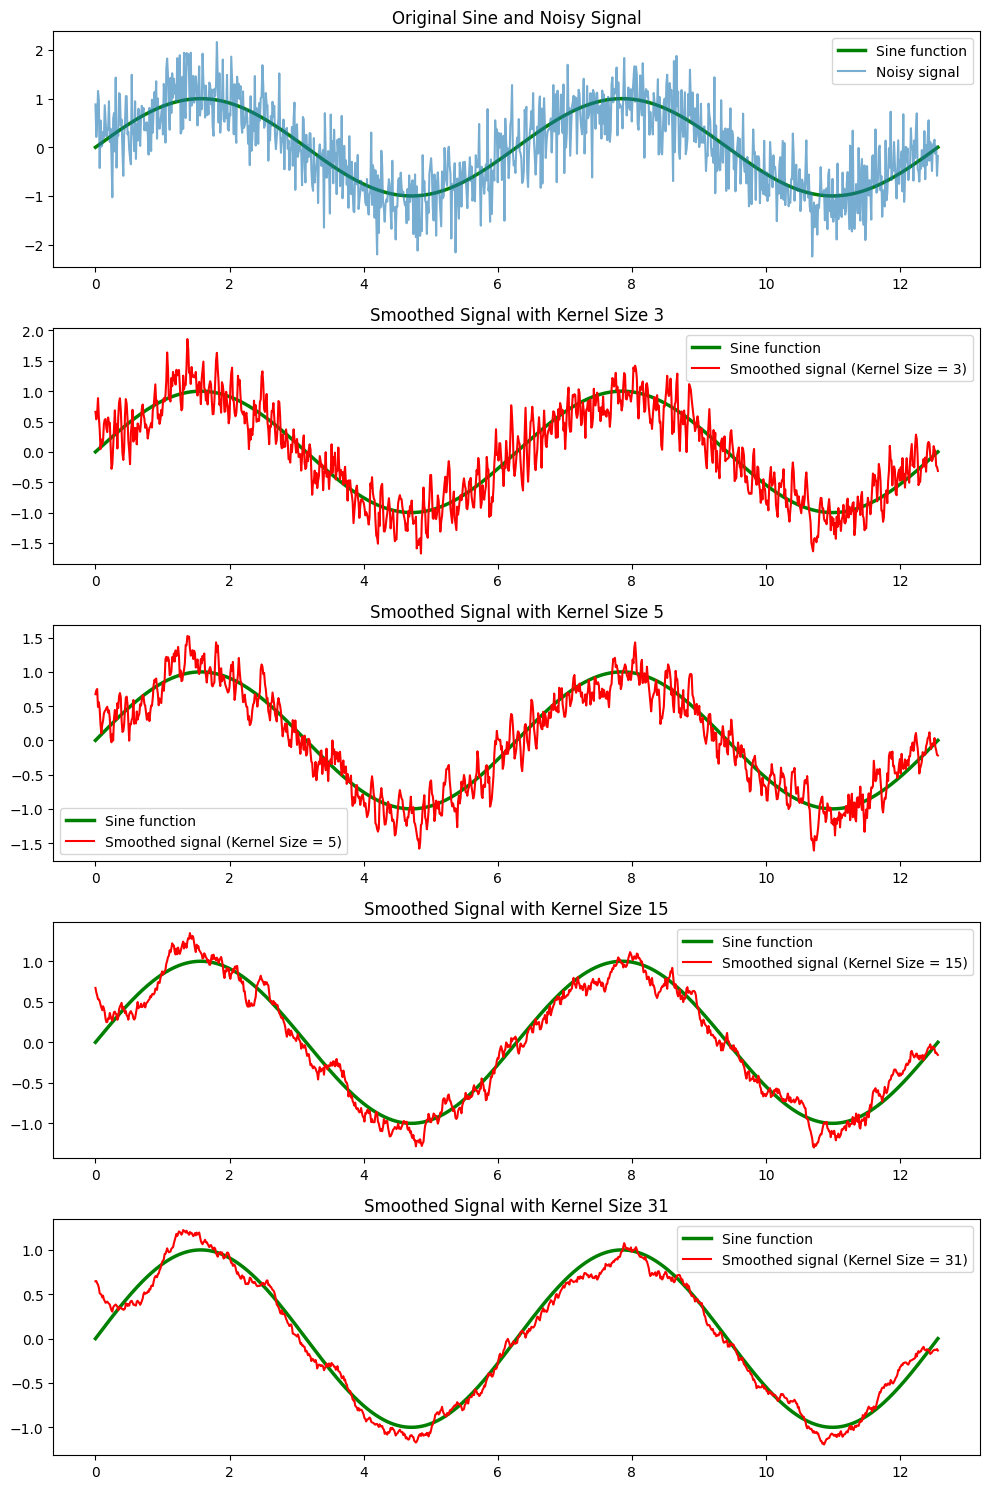

In [38]:
# Extra plots would be nice
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].plot(x, y_sin, label="sine function", linewidth=2.5, color='green')
axs[0].plot(x, smoothed_y, 'r', label='Smoothed signal')
axs[0].legend()
axs[0].set_title('Sine Function and Smoothed Signal')

axs[1].plot(x, y_sin, label="sine function", linewidth=2.5, color='green')
axs[1].plot(x, y, label='Noisy signal')
axs[1].legend()
axs[1].set_title('Sine Function and Noisy Signal')

plt.tight_layout()
plt.show()

2d CONVOLUTION OPERATION

In [39]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def conv2d(image: np.array, kernel:np.array, pad: bool, pad_size: int = 0):

    if len(image.shape) == 2:
        image_height, image_width = image.shape
        num_channels = 1
        image = np.expand_dims(image, -1) # Adding channel dimension for grayscale image
    else:
        image_height, image_width, num_channels = image.shape

    kernel_height, kernel_width = kernel.shape

    if pad:
        padded_image = np.pad(image, ((pad_size,pad_size),
                                      (pad_size,pad_size),
                                      (0,0)), mode='constant')
        output_height = image_height + 2*pad_size - kernel_height + 1
        output_width = image_width + 2*pad_size - kernel_width + 1
    else:
        padded_image = image
        output_height = image_height - kernel_height + 1
        output_width = image_width - kernel_width + 1

    output = np.zeros((output_height, output_width, num_channels))

    kernel = np.expand_dims(kernel, -1)
    kernel = np.repeat(kernel, num_channels, axis=-1) # Ensure kernel shape matches image

    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = (padded_image[i:i+kernel_height, j:j+kernel_width] * kernel).sum(0).sum(0)

    if num_channels == 1:
        output = np.squeeze(output, -1) # Remove channel axis for grayscale image

    return output

In [41]:
# Student should show that function works for both RGB and grayscale images
# or if student only shows output on RGB image, then later we will see
# if that function works on grayscale images on the 2nd part of this task(sobel operator)
# Showing different blur intensities is not needed but is a plus if student explores this area.
blur_intensity_3 = 3
blur_intensity_9 = 9
blur_kernel_3 = np.array([[1/(blur_intensity_3**2) for _ in range(blur_intensity_3)] for _ in range(blur_intensity_3)])
blur_kernel_9 = np.array([[1/(blur_intensity_9**2) for _ in range(blur_intensity_9)] for _ in range(blur_intensity_9)])
img_gray = Image.open("some_image.png").convert("L")
img_rgb = Image.open("some_image.png").convert("RGB")
img_gray = np.array(img_gray)
img_rgb = np.array(img_rgb)

img_conv_gray = conv2d(img_gray, blur_kernel_3, True, 1)
img_conv_rgb = conv2d(img_rgb, blur_kernel_9, True, 1)
img_conv_rgb = img_conv_rgb.astype(np.uint8)
img_conv_gray = img_conv_gray.astype(np.uint8)

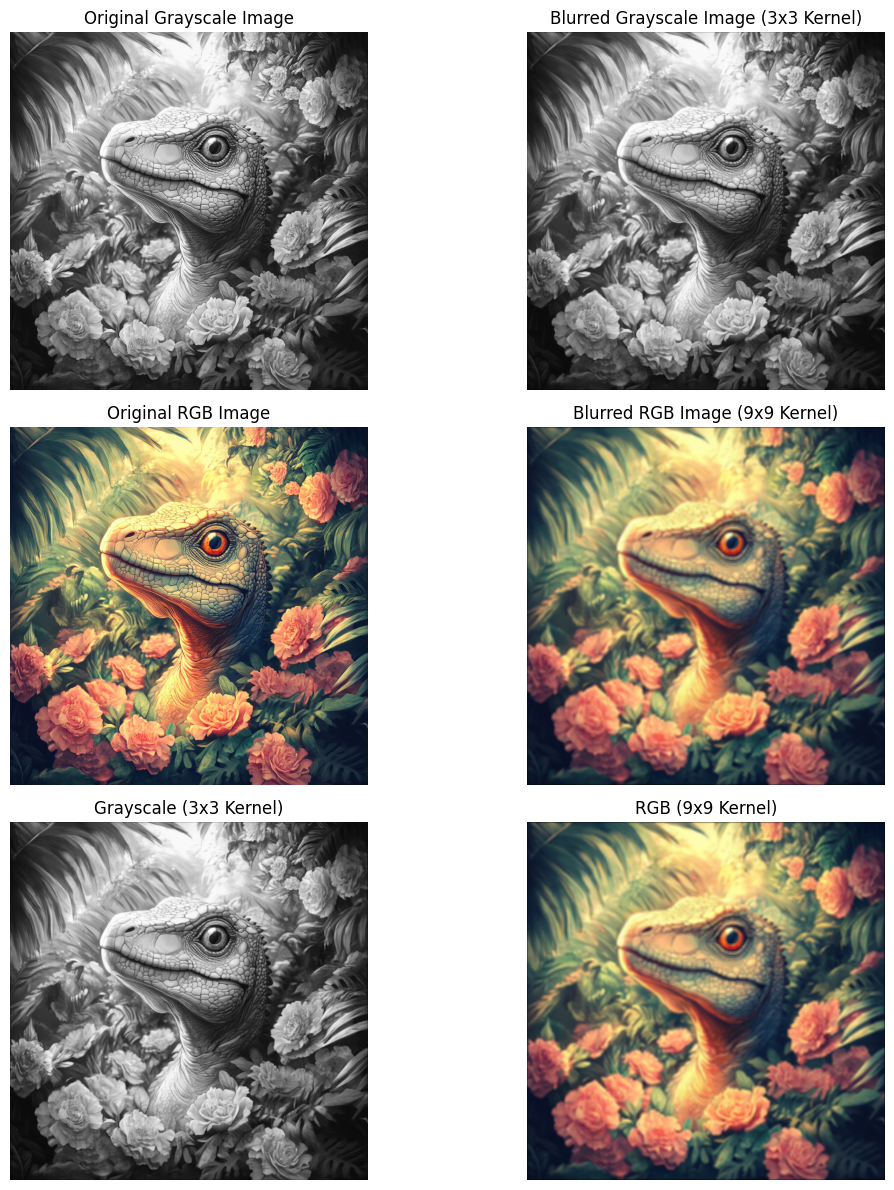

In [42]:
plt.imshow(img_conv_gray, cmap="gray")
plt.show()

plt.imshow(img_conv_rgb)
plt.show()

In [44]:
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

img = np.array(Image.open("some_image.png").convert("L"))
img_edges_x = conv2d(img, sobel_x, True, 1)
img_edges_y = conv2d(img, sobel_y, True, 1)

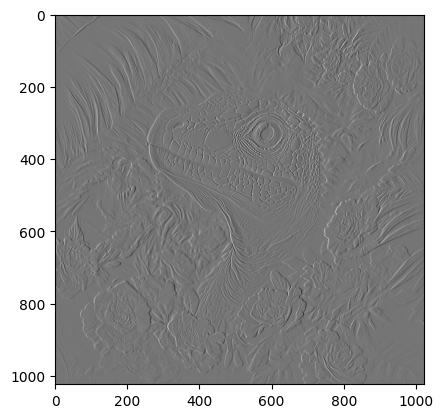

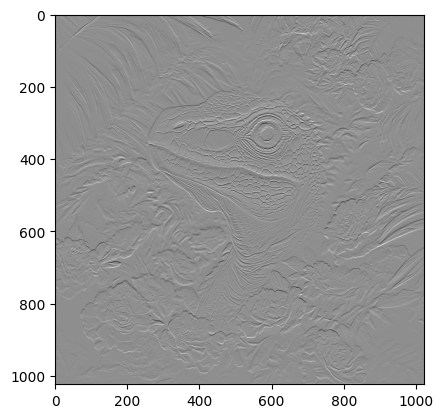

In [45]:
img_edges_y.astype(np.uint8)
plt.imshow(img_edges_x, cmap="gray")
plt.show()

img_edges_x.astype(np.uint8)
plt.imshow(img_edges_y, cmap="gray")
plt.show()